In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
import os
import cv2

import glob
import piexif

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, ZeroPadding2D, MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from keras.models import save_model, load_model
from keras.callbacks import ModelCheckpoint

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from keras.applications.resnet50 import ResNet50
from keras.models import Model

import shutil

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
IMAGE_SIZE = 200
CHANNELS = 3
BATCH_SIZE = 8
NUM_EPOCH = 5
LEARN_RATE = 1.0e-4
ALL_DIR = '../data/train'
TESTING_DIR = '../data/test'
VAL_DIR = '../data/val'
TR_DIR = '../data/tr'
DEBUG_DIR = '../data/debug'
SAVED_MODEL = 'resnet_model.h5'
SEED = 42

split_train_valid_done = True


In [3]:
# credits: @daanraman https://github.com/keras-team/keras/issues/5862
def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct):
    # Recreate testing and training directories
    if testing_data_dir.count('/') > 1:
        shutil.rmtree(testing_data_dir, ignore_errors=False)
        os.makedirs(testing_data_dir)
        print("Successfully cleaned directory " + testing_data_dir)
    else:
        print("Refusing to delete testing data directory " + testing_data_dir + " as we prevent you from doing stupid things!")

    if training_data_dir.count('/') > 1:
        shutil.rmtree(training_data_dir, ignore_errors=False)
        os.makedirs(training_data_dir)
        print("Successfully cleaned directory " + training_data_dir)
    else:
        print("Refusing to delete testing data directory " + training_data_dir + " as we prevent you from doing stupid things!")

    num_training_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = os.path.basename(subdir)

        # Don't create a subdirectory for the root directory
        print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name

        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)

        for file in files:
            input_file = os.path.join(subdir, file)
            if np.random.rand(1) < testing_data_pct:
                shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
                num_testing_files += 1
            else:
                shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
                num_training_files += 1

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")


In [4]:
def remove_exif(files):
    tmp = []
    for file in files:
        piexif.remove(file)
            
def pre_process():
    type1 = glob.glob("{}/Type_1/*.jpg".format(TRAINING_DIR))
    type2 = glob.glob("{}/Type_2/*.jpg".format(TRAINING_DIR))
    type3 = glob.glob("{}/Type_3/*.jpg".format(TRAINING_DIR))
    test = glob.glob("{}/*.jpg".format(TESTING_DIR))
        
    type1_filenames = remove_exif(type1)
    type2_filenames = remove_exif(type2)
    type3_filenames = remove_exif(type3)

def extract_filename(files):
    tmp = []
    for file in files:
        parts = file.split('/')
        tmp.append(parts[-1].replace('.jpg', ''))
    return np.array(tmp)

In [5]:
def create_data_generators(validation_set = False):
    
    

    if not validation_set:
        data_generator = ImageDataGenerator()
        return data_generator.flow_from_directory(TR_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=SEED,
                                                         class_mode='categorical', batch_size=BATCH_SIZE)
    else:
        valid_data_generator = ImageDataGenerator()
        return valid_data_generator.flow_from_directory(VAL_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=SEED,
                                                         class_mode='categorical', batch_size=BATCH_SIZE,)
        
def create_test_generators():
    data_generator = ImageDataGenerator()
    return data_generator.flow_from_directory(TESTING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=SEED,
                                                         class_mode='categorical', batch_size=BATCH_SIZE)


In [6]:
def create_data_generator_from_array(raw_data, batch_size, folder, evaluate=False):
    labels = ["Type_1", "Type_2", "Type_3"]
    while True:
        X = np.zeros((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=np.float32)
        Y = np.zeros((batch_size, 3), dtype=np.float32)
        cnt = 0
        for i, (image_name, image_class) in enumerate(raw_data):
            file_path = os.path.join(folder,image_class, image_name + '.jpg')        
            
            image = cv2.imread(file_path)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            #image = image.transpose([2,0,1])
            image = image.astype(np.float32) / 255.0
            X[cnt, :, :, :] = image
            class_index = labels.index(image_class)
            Y[cnt, class_index] = 1
                
            cnt += 1
            if cnt == batch_size:
                yield (X, Y)
                X = np.zeros((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=np.float32)
                Y = np.zeros((batch_size, 3), dtype=np.float32)
                cnt = 0

        if cnt > 0:
            X = X[:cnt,:,:,:]
            Y = Y[:cnt,:]

            yield (X, Y) 
        
        if evaluate:
            break


def validatione_iterator(evaluate=False):
    type1 = glob.glob("{}/Type_1/*.jpg".format(VAL_DIR))
    type2 = glob.glob("{}/Type_2/*.jpg".format(VAL_DIR))
    type3 = glob.glob("{}/Type_3/*.jpg".format(VAL_DIR))
    
    type1_filenames = extract_filename(type1)
    type2_filenames = extract_filename(type2)
    type3_filenames = extract_filename(type3)
    all_filenames = [type1_filenames, type2_filenames, type3_filenames]
    
    valid_sizes = [int(len(ids) * 1) for ids in all_filenames]
    
    
    valid_type1 = type1_filenames[:valid_sizes[0]]
    valid_type2 = type2_filenames[:valid_sizes[1]]
    valid_type3 = type3_filenames[:valid_sizes[2]]

    
    labels = ["Type_1", "Type_2", "Type_3"]

    valid_all = []
    

    #train
    for img in valid_type1:
        valid_all.append((img, labels[0]))

    for img in valid_type2:
        valid_all.append((img, labels[1]))

    for img in valid_type3:
        valid_all.append((img, labels[2]))

    
    
    validation_iter =  create_data_generator_from_array(valid_all, BATCH_SIZE, VAL_DIR, evaluate)
    
    return validation_iter


In [7]:
def build_model():
#     model = Sequential()
#     model.add(Convolution2D(4, 3, 3, activation='relu', dim_ordering='th', input_shape=(3, 32, 32))) #use input_shape=(3, 64, 64)
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))
#     model.add(Convolution2D(8, 3, 3, activation='relu', dim_ordering='th'))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))
#     model.add(Dropout(0.2))
    
#     model.add(Flatten())
#     model.add(Dense(12, activation='tanh'))
#     model.add(Dropout(0.1))
#     model.add(Dense(3, activation='softmax'))
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    model.summary()
    return model


In [8]:
def compile_model(model):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

In [9]:
def train_model(model, train_generator, validation_generator, step_train, step_valid):
    checkpoint = ModelCheckpoint(SAVED_MODEL,  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=1, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor
    
    history = model.fit_generator(
            train_generator,
            steps_per_epoch=step_train,
            epochs=NUM_EPOCH,
            callbacks=[checkpoint],
            validation_data=validation_generator,
            validation_steps=step_valid)
            
    model.save(SAVED_MODEL)
    return history

In [10]:
def logloss_mc(y_true, y_prob, epsilon=1e-15):
    """ Multiclass logloss
    This function is not officially provided by Kaggle, so there is no
    guarantee for its correctness.
    https://github.com/ottogroup/kaggle/blob/master/benchmark.py
    """
    # normalize
    y_prob = y_prob / y_prob.sum(axis=1).reshape(-1, 1)
    y_prob = np.maximum(epsilon, y_prob)
    y_prob = np.minimum(1 - epsilon, y_prob)
    # get probabilities
    y = [y_prob[i, j] for (i, j) in enumerate(y_true)]
    ll = - np.mean(np.log(y))
    return ll

In [11]:
def evaluate_model(model, validation_generator):
    total_loss = 0.0
    total_counter = 0 

    for X, Y_true in validation_generator:

        s = Y_true.shape[0]
        total_counter += s

        Y_pred = model.predict(X)
        loss = logloss_mc(Y_true.astype(np.int), Y_pred)
        print("--", total_counter, "batch loss : ", loss)
        total_loss += s * loss
    
    if (total_counter > 0):
        total_loss *= 1.0 / total_counter   
    return total_loss

In [12]:
def get_test_dataset_iter(raw_data, batch_size, folder):
    labels = ["Type_1", "Type_2", "Type_3"]
    while True:
        X = np.zeros((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=np.float32)
        Y = np.empty((batch_size,), dtype=np.object)
        cnt = 0
        for i, (image_name, image_class) in enumerate(raw_data):
            if image_class == 'Test':
                file_path = os.path.join(folder, image_name + '.jpg')
            else: 
                file_path = os.path.join('../data/test_stg2', image_name + '.jpg')
            
            image = cv2.imread(file_path)

            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            #image = image.transpose([2,0,1])
            image = image.astype(np.float32) / 255.0
            X[cnt, :, :, :] = image
            Y[cnt] = str(image_name)
            cnt += 1
            if cnt == batch_size:
                yield (X, Y)
                X = np.zeros((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=np.float32)
                Y = np.empty((batch_size,), dtype=np.object)
                cnt = 0

        if cnt > 0:
            X = X[:cnt,:,:,:]
            Y = Y[:cnt]

            yield (X, Y) 

        break
        
def gen_submission_dataframe(model, test_iter):
    df = pd.DataFrame(columns=['image_name','Type_1','Type_2','Type_3'])
    cnt = 0
    for X, Y in test_iter:
        y_pred = model.predict(X)
        s = X.shape[0]

        for i in range(s):
            df.loc[cnt + i, :] = (Y[i] + '.jpg', ) + tuple(y_pred[i, :])
        cnt += s 
    return df
        
def make_predictions(model):
    test = glob.glob('../data/test/*.jpg')
    test2 = glob.glob('../data/test_stg2/*.jpg')

    test_filenames = extract_filename(test)
    test_filenames2 = extract_filename(test2)

    test_all = []
    for img in test_filenames:
        test_all.append((img, 'Test'))

    for img in test_filenames2:
        test_all.append((img, 'Test2'))
    

    test_iter = get_test_dataset_iter(test_all, BATCH_SIZE, TESTING_DIR)
    
    
    return gen_submission_dataframe(model, test_iter)
    
def save_submission(df):

    sub_file = 'submission_' + str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + '.csv'
    df.to_csv(sub_file, index=False)

def load_model_from_file(file):
    return load_model(file)

def visualize_train_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [13]:
if not split_train_valid_done:
    split_dataset_into_test_and_train_sets(ALL_DIR, TR_DIR, VAL_DIR, 0.2)

In [14]:
train_generator = create_data_generators()
validation_generator = create_data_generators(True)

step_size_train=train_generator.n//BATCH_SIZE
step_size_valid=validation_generator.n//BATCH_SIZE

print(step_size_train, step_size_valid)


Found 1167 images belonging to 3 classes.
Found 314 images belonging to 3 classes.
145 39


In [15]:
## Build model

#model = load_model_from_file('')
model = build_model()
compile_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1254528)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3763587   
Total params: 3,764,483
Trainable params: 3,764,483
Non-trainable params: 0
_________________________________________________________________


In [16]:
## Train

history = train_model(model, train_generator, validation_generator, step_size_train, step_size_valid)

Epoch 1/5
145/145 [==============================] - 431s 3s/step - loss: 13.4594 - acc: 0.1648 - val_loss: 12.9668 - val_acc: 0.1955

Epoch 00001: val_loss improved from inf to 12.96680, saving model to resnet_model.h5
Epoch 2/5
145/145 [==============================] - 446s 3s/step - loss: 13.5019 - acc: 0.1623 - val_loss: 12.9577 - val_acc: 0.1961

Epoch 00002: val_loss improved from 12.96680 to 12.95768, saving model to resnet_model.h5
Epoch 3/5
145/145 [==============================] - 439s 3s/step - loss: 13.5019 - acc: 0.1623 - val_loss: 13.0630 - val_acc: 0.1895

Epoch 00003: val_loss did not improve from 12.95768
Epoch 4/5
145/145 [==============================] - 444s 3s/step - loss: 13.5197 - acc: 0.1612 - val_loss: 13.0104 - val_acc: 0.1928

Epoch 00004: val_loss did not improve from 12.95768
Epoch 5/5
145/145 [==============================] - 433s 3s/step - loss: 13.5475 - acc: 0.1595 - val_loss: 12.9050 - val_acc: 0.1993

Epoch 00005: val_loss improved from 12.95768 t

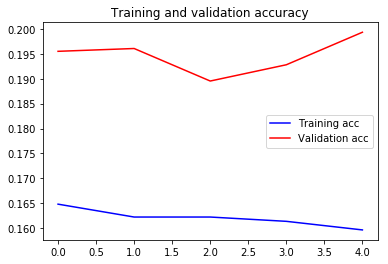

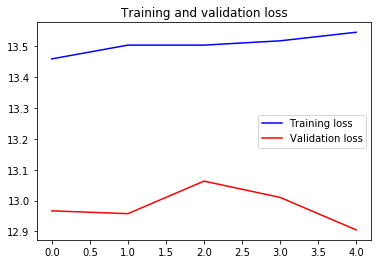

In [17]:
## Visualization

visualize_train_history(history)

In [18]:
## Evaluate

vg = validatione_iterator(True) 

total_loss = evaluate_model(model, vg)
print("Total loss : ", total_loss)

-- 8 batch loss :  11.512925
-- 16 batch loss :  11.512925
-- 24 batch loss :  11.512925
-- 32 batch loss :  11.512925
-- 40 batch loss :  11.512925
-- 48 batch loss :  11.512925
-- 56 batch loss :  11.512925
-- 64 batch loss :  11.512925
-- 72 batch loss :  11.512925
-- 80 batch loss :  11.512925
-- 88 batch loss :  11.512925
-- 96 batch loss :  11.512925
-- 104 batch loss :  11.512925
-- 112 batch loss :  11.512925
-- 120 batch loss :  11.512925
-- 128 batch loss :  11.512925
-- 136 batch loss :  11.512925
-- 144 batch loss :  11.512925
-- 152 batch loss :  11.512925
-- 160 batch loss :  11.512925
-- 168 batch loss :  11.512925
-- 176 batch loss :  11.512925
-- 184 batch loss :  11.512925
-- 192 batch loss :  11.512925
-- 200 batch loss :  11.512925
-- 208 batch loss :  11.512925
-- 216 batch loss :  11.512925
-- 224 batch loss :  11.512925
-- 232 batch loss :  11.512925
-- 240 batch loss :  11.512925
-- 248 batch loss :  11.512925
-- 256 batch loss :  11.512925
-- 264 batch loss :  

In [19]:
# # Predict

# df = make_predictions(model)
# save_submission(df)